In [1]:
import numpy as np
import data_in_out as IO
import velocities as vl
import visualization as vis
from matplotlib import pyplot as plt
import pitchcontrol as pc
import ept
import matplotlib.animation as animation
import os
import pandas as pd
pd.set_option('display.float_format', '{:.5f}'.format)
FC_TWENTE_FOLDER = os.path.join(os.getcwd(), "FC_TWENTE_FOLDER")
print(FC_TWENTE_FOLDER)

/home/jovyan/FC_Twente/FC_TWENTE_FOLDER


***Pre processing event of 1st match***

***Note***: Change "game_id" to process event of different match

***Note:***
Run this code below once to generate processed_events.csv then comment it out(it will take around 7-8 mins)

In [2]:
game_id = 1

In [3]:
##Store and Load processed_events
# events = IO.processing_events_data(events, game_id=game_id)
# events.to_csv("processed_events.csv")
# csv_path = os.path.join(os.getcwd(), "processed_events.csv")
# events= pd.read_csv(csv_path)

***Load processed events tracking data***


In [4]:
events= IO.load_fc_twente_data(game_id=game_id, mode="load-process-event")
events.head(5)


Loading Game 1 data...
Loading process event data


,Unnamed: 0.1,Unnamed: 0,period_id,minute,second,outcome,start_x,start_y,end_x,end_y,type_name,FullName,Position,Team,start_frameID
0,0,0,1,0,0,True,52.50000,34.00000,31.82000,32.10000,Pass,Team_A_Player_10,Striker,Team_A,1104770
1,1,1,1,0,2,True,31.82000,31.96000,86.20000,67.12000,Pass,Team_A_Player_4,Defender,Team_A,1104820
2,2,2,1,0,8,True,14.60000,-0.95000,14.60000,-0.95000,Out,Team_B_Player_4,Defender,Team_B,1104990
3,3,3,1,0,8,False,90.40000,68.95000,90.40000,68.95000,Out,Team_A_Player_4,Defender,Team_A,1104989
4,4,4,1,0,20,True,17.22000,0.00000,30.87000,21.08000,Pass,Team_B_Player_4,Defender,Team_B,1105294


***Load tracking data for team 1 and team 2***

In [5]:
home = (IO.load_fc_twente_data(game_id=game_id, team_id="A", mode="load-team-data"))
away = (IO.load_fc_twente_data(game_id=game_id, team_id="B", mode="load-team-data"))
ball = IO.load_fc_twente_data(game_id=game_id, mode="load-ball-data")
ball['frameID'] = ball['frameID'].astype(int)
ball = ball.set_index('frameID')

Loading Game 1 data...
Loading team A data of Game 1...
Loading Game 1 data...
Loading team B data of Game 1...
Loading Game 1 data...
Loading ball data of Game 1...


***Convert coordinate and calulate velocities for each player***


In [6]:
home = IO.to_metric_coordinates(home)
away = IO.to_metric_coordinates(away)
home = vl.calc_player_velocities(home)
away = vl.calc_player_velocities(away)
events = IO.to_metric_coordinates(events)
ball = IO.to_metric_coordinates(ball)

In [7]:
events.head(1)

,Unnamed: 0.1,Unnamed: 0,period_id,minute,second,outcome,start_x,start_y,end_x,end_y,type_name,FullName,Position,Team,start_frameID
0,0,0,1,0,0,True,0.00000,0.00000,-20.68000,-1.90000,Pass,Team_A_Player_10,Striker,Team_A,1104770


***Pitch control model***


In [8]:
event_id = 6
params = pc.default_model_params(3)
tracking_home = home
tracking_away = away
GK_numbers = [IO.find_goalkeeper(tracking_home),IO.find_goalkeeper(tracking_away)]

PPCFa,xgrid,ygrid = pc.generate_pitch_control_for_event(event_id, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (105.,68.,), n_grid_cells_x = 50, offsides=True)

Event id = 6
Frame id = 1105419
Pass teamTeam_A
Ball pos = [ 6.51 14.96]


In [9]:
# vis.generate_video(home[:50], away[:50], ball[:50])

(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

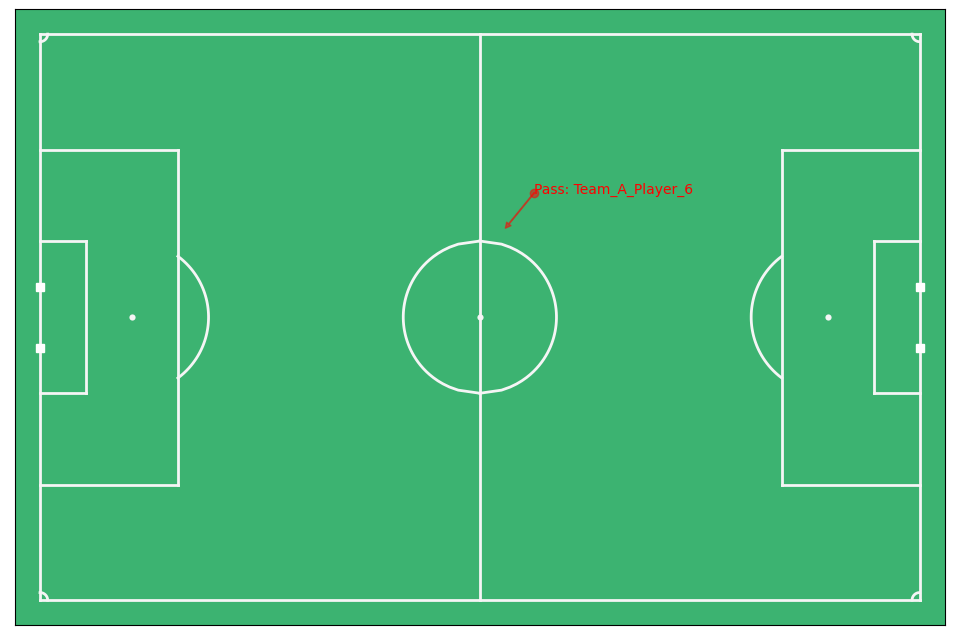

In [10]:
vis.plot_events(events.iloc[(event_id):(event_id+1)], annotate=True)

(<Figure size 1200x800 with 1 Axes>, <AxesSubplot: >)

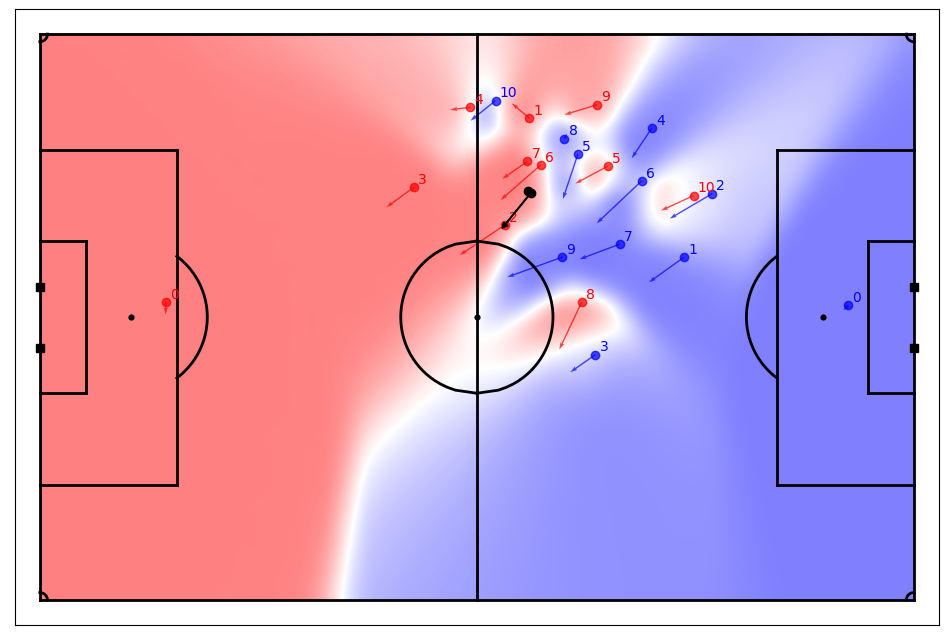

In [11]:
vis.plot_pitchcontrol_for_event(event_id, events, home, away, ball, PPCFa, annotate=True)

***Expected Threat(xT) model***


***Note:***
Load expected threat(xT) grid generated by "xThreat_model.ipynb"

In [12]:
xT_model = ept.load_xT_grid(os.path.join(os.getcwd(), "xT.csv"))

In [13]:
ept.calculate_action_value_added(event_id, events, tracking_home, tracking_away, GK_numbers, xT_model, params)

(-0.0034217003937001833, -0.002522980210682542)

***Calculate Action Value ***


In [14]:
passes_events = events.loc[events['type_name'] == 'Pass']
print(len(passes_events))

1090


In [15]:
action_values = []
for index, row in passes_events.iterrows():
    event_id = index
    action_value, xT_difference = ept.calculate_action_value_added(event_id, events, tracking_home, tracking_away, GK_numbers, xT_model, params)
    action_values.append(action_value)
passes_events['action_value'] = action_values

/tmp/ipykernel_2600/3601606292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_events['action_value'] = action_values


In [16]:
passes_events['action_value'].head(5)

0   -0.01616
1   -0.01814
4    0.00000
5    0.00000
6   -0.00342
Name: action_value, dtype: float64

In [17]:
copy_events = passes_events.copy()

sf = copy_events.groupby('FullName').sum()['action_value'].sort_values(ascending=False)
action_value_frame = pd.DataFrame({'FullName':sf.index, 'action_value':sf.values})
action_value_frame.set_index('FullName', inplace=True)
sf = copy_events.groupby('FullName').size()
num_passes_frame = pd.DataFrame({'FullName':sf.index, 'num_passes':sf.values})
num_passes_frame.set_index('FullName', inplace=True)

In [18]:
num_passes_frame.head()

,num_passes
FullName,
Team_A_Player_0,32
Team_A_Player_1,43
Team_A_Player_10,17
Team_A_Player_11,2
Team_A_Player_16,3


***Group action value per player with relevant information***


In [19]:
position_frames = copy_events[['FullName', 'Position', 'Team']].copy()
position_frames = position_frames.drop_duplicates()
position_frames.set_index('FullName', inplace=True)

In [20]:
result = pd.concat([num_passes_frame,action_value_frame, position_frames], axis=1, join='outer')
result['avg_action_value'] = result['action_value'] /result['num_passes']
result = result.rename({'action_value': 'total_action_value'}, axis='columns')
result['Position'] = result['Position'].replace('Forward','Striker')
result

,num_passes,total_action_value,Position,Team,avg_action_value
FullName,,,,,
Team_A_Player_0,32,0.57539,Goalkeeper,Team_A,0.01798
Team_A_Player_1,43,0.49757,Defender,Team_A,0.01157
Team_A_Player_10,17,0.22378,Striker,Team_A,0.01316
Team_A_Player_11,2,-0.00000,Striker,Team_A,-0.00000
Team_A_Player_16,3,0.09597,Striker,Team_A,0.03199
Team_A_Player_19,1,-0.04066,Striker,Team_A,-0.04066
Team_A_Player_2,34,0.18351,Defender,Team_A,0.00540
Team_A_Player_3,55,0.79273,Defender,Team_A,0.01441
Team_A_Player_4,58,0.63523,Defender,Team_A,0.01095


In [21]:
result.sort_values(by=['total_action_value'])

,num_passes,total_action_value,Position,Team,avg_action_value
FullName,,,,,
Team_B_Player_0,19,-1.45894,Goalkeeper,Team_B,-0.07679
Team_B_Player_1,94,-1.11863,Defender,Team_B,-0.01190
Team_B_Player_9,30,-0.07035,Striker,Team_B,-0.00235
Team_A_Player_19,1,-0.04066,Striker,Team_A,-0.04066
Team_A_Player_11,2,-0.00000,Striker,Team_A,-0.00000
Team_B_Player_20,24,0.00427,Striker,Team_B,0.00018
Team_B_Player_10,11,0.01660,Striker,Team_B,0.00151
Team_B_Player_8,25,0.01768,Midfielder,Team_B,0.00071
Team_B_Player_2,40,0.02416,Defender,Team_B,0.00060


/tmp/ipykernel_2600/1311699717.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


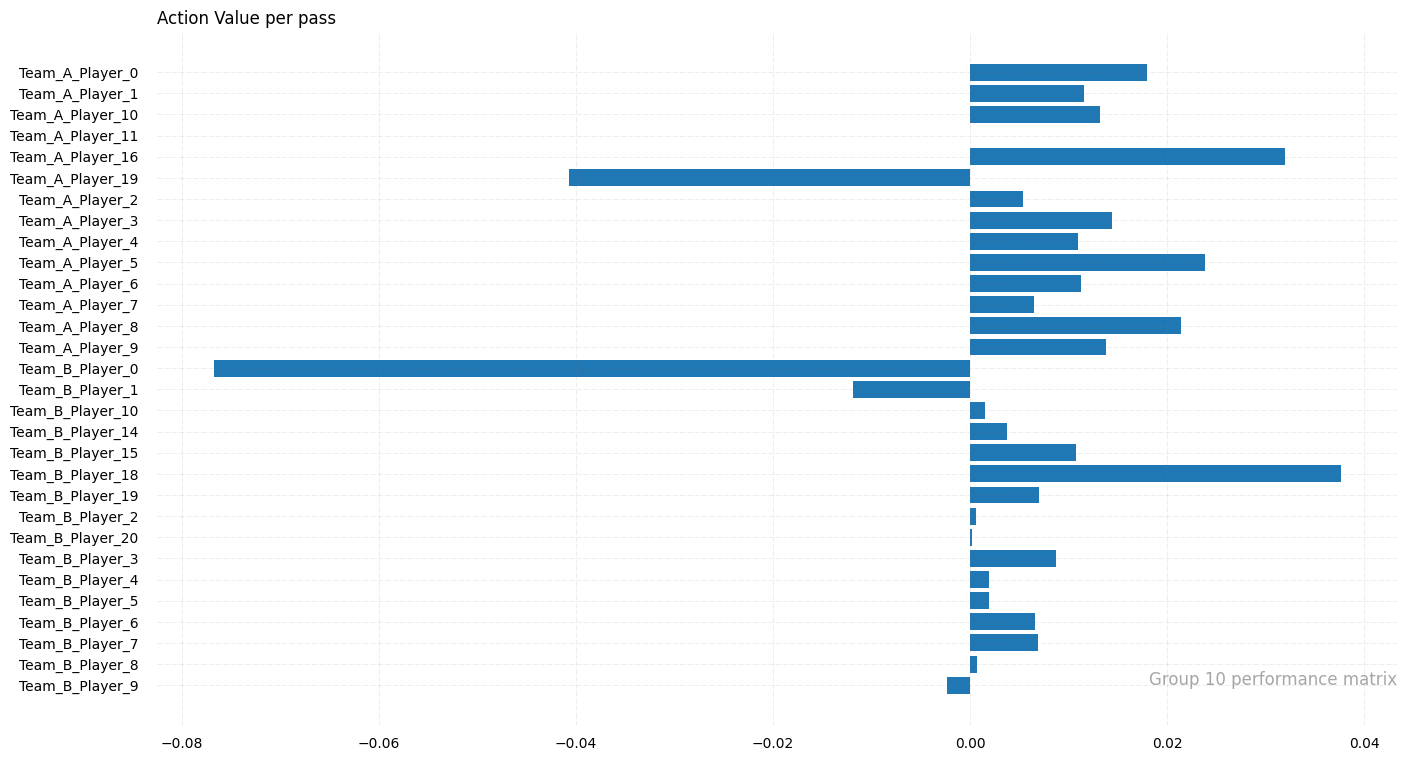

In [22]:
avg_action_value = result['avg_action_value']
players = result.index
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(players, avg_action_value)
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add Plot Title
ax.set_title('Action Value per pass',
             loc ='left', )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Group 10 performance matrix', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

***Group action value per position***


In [23]:
results_by_position = result.groupby(['Position','Team']).sum()['total_action_value']/result.groupby(['Team','Position']).sum()['num_passes']

results_by_position


Position    Team  
Defender    Team_A    0.01110
            Team_B    0.00126
Goalkeeper  Team_A    0.01798
            Team_B   -0.07679
Midfielder  Team_A    0.01458
            Team_B    0.00736
Striker     Team_A    0.01684
            Team_B    0.00047
dtype: float64

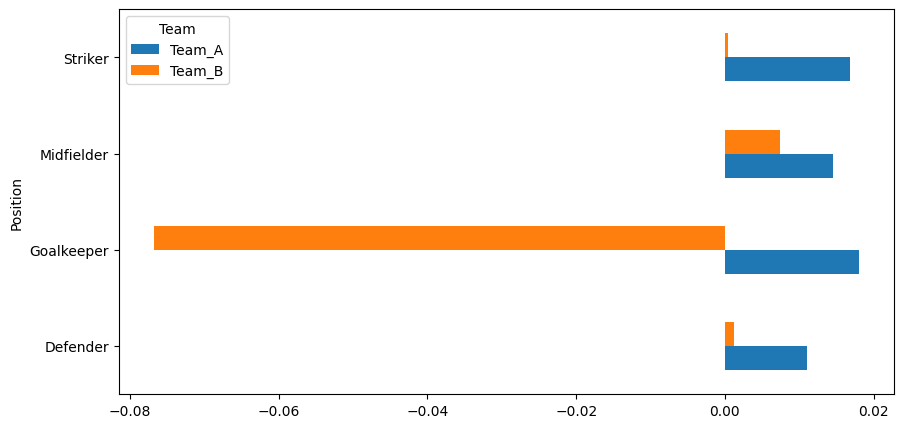

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
results_by_position.unstack().plot.barh(ax=ax)
plt.show()